In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:
#input_dir = 'output-files-bootstrap-test7-2d'

#input_dir = 'output-files-bootstrap-test6b-2d-2a-100k'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-v1b'

#input_dir = 'output-files-bootstrap-test6b-2d-2a'




#input_dir = 'bootstrap-toy-study6b-2d-4c'

input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-4c'





with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (100000, 2)
 shape of true_pts:   (10000, 2)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 2




In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

<function matplotlib.pyplot.show(close=None, block=None)>

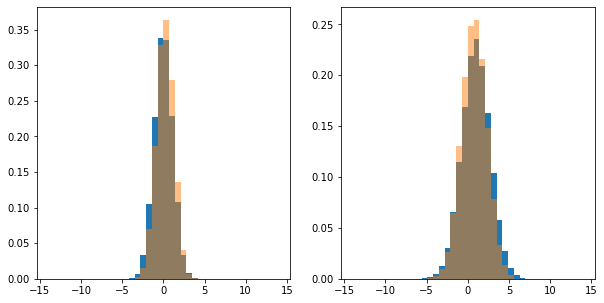

In [6]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))



hmin=-5
hmax=5


hmin=-14
hmax=14

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

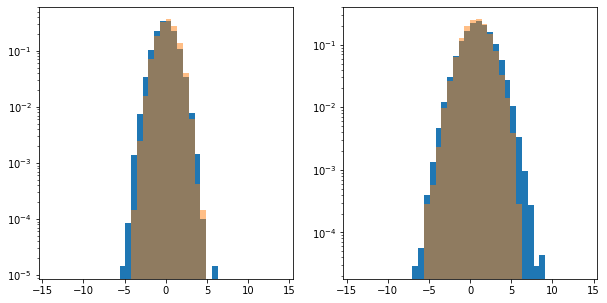

In [7]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
        ax[i].set_yscale('log')
    
plt.show

In [8]:
with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)


In [9]:
main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

<function matplotlib.pyplot.show(close=None, block=None)>

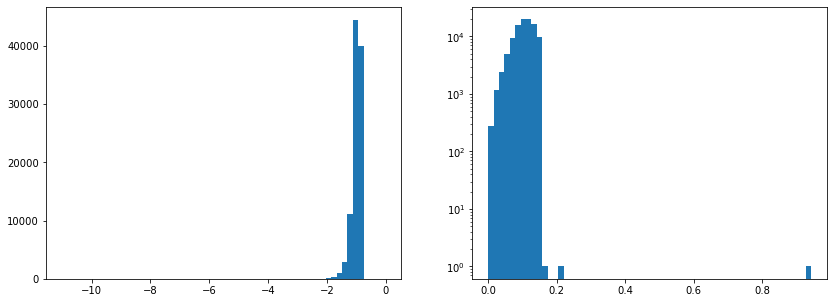

In [10]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(main_sample_omnifold_weights), bins=hbins)
ax[1].hist( main_sample_omnifold_weights, bins=hbins)
ax[1].set_yscale('log')
plt.show

In [11]:
true_rho

array([[-0.6]])

In [12]:
true_mu.shape

(2,)

In [13]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

 0, 1, 0


In [14]:
true_cov

array([[ 0.81 , -0.702],
       [ 0.   ,  1.69 ]])

In [15]:
have_fits = False

if exists( "%s/fit-results.npy" % input_dir ) :
    have_fits = True
    print("\n\n Have fit results file.\n\n")



 Have fit results file.




In [16]:
if have_fits :
    
    with open( '%s/fit-results.npy' % input_dir, 'rb' ) as f :
        fit_results_mean_val = np.load(f, allow_pickle=True )
        fit_results_mean_err = np.load(f, allow_pickle=True )
        fit_results_cov_val = np.load(f, allow_pickle=True )
        fit_results_cov_err = np.load(f, allow_pickle=True )        
        

    ave_fit_err_mean = np.zeros( ndim )
    
    ave_fit_err_cov = np.zeros( shape=(ndim,ndim) )

    for fi in range(ndim) :
    
        ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])
        
        print( '%d : ave fit error, mean :  %8.4f' % (fi, ave_fit_err_mean[fi]))
        
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            
            
            ave_fit_err_cov[fi1,fi2] = np.mean( fit_results_cov_err[fi1,fi2,:])
            
            print( 'fi1, fi2 : %d, %d    ave fit error, cov : %8.4f' % (fi1,fi2, ave_fit_err_cov[fi1,fi2]))
    

0 : ave fit error, mean :    0.0090
1 : ave fit error, mean :    0.0128
fi1, fi2 : 0, 0    ave fit error, cov :   0.0117
fi1, fi2 : 0, 1    ave fit error, cov :   0.0136
fi1, fi2 : 1, 1    ave fit error, cov :   0.0237


In [17]:
def calc_mean( weights, fi ) :
    
    mean = ( np.sum( weights * train_pts[:,fi]) ) / ( np.sum( weights ) )
    
    return mean

In [18]:
def calc_rms( weights, fi ) :
    
    x = calc_mean( weights, fi )
    xx = ( np.sum( weights * train_pts[:,fi] * train_pts[:,fi] ) ) / ( np.sum( weights ) )
    
    #print(" x = %f,  xx = %f" % (x, xx))
    
    return np.sqrt(xx - x*x)


In [19]:
def calc_cov( weights, fi1, fi2 ) :
    
    x1 = calc_mean( weights, fi1 )
    x2 = calc_mean( weights, fi2 )
    x1x2 = ( np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] ) ) / ( np.sum( weights ) )
    
    return np.sqrt( x1x2 - x1*x2 )
    

In [20]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [21]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 100 bootstrap samples.




In [22]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )


si = 0

for fi in range(500) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            print( len(final_push_weights_scaled))
            print( final_push_weights_scaled )
            print( true_pts[:,0])
            
            all_weight_min[si] = np.min( final_push_weights_scaled )
            all_weight_max[si] = np.max( final_push_weights_scaled )
            
            for fi1 in range(ndim) :
                for fi2 in range(fi1,ndim) :
                    mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                    all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                    all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                    if ( fi1 == fi2 ) :
                        print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                              (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                        all_mean[fi1,si] = mean_cov["mean_x1"]
                        all_rms[fi1,si] = mean_cov["rms1"]
                    else :
                        print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                              (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                        all_rho[fi1,fi2,si] = mean_cov["rho12"]
                        all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- bootstrap-simple-pdf-toy-study6b-2d-4c/bootstrap-weights-000.npy exists
100000
[0.06123674 0.08537678 0.02759656 ... 0.07235463 0.10618998 0.10120787]
[ 0.34426023 -0.15155005  0.31560852 ...  0.21250232  1.45614692
  0.08527077]
  0 0  :  mean =   0.2005, RMS =   0.9207, cov =   0.8478
  0 1  :  rho =  -0.5778,  cov =  -0.6953
  1 1  :  mean =   0.8072, RMS =   1.3069, cov =   1.7079

----- bootstrap-simple-pdf-toy-study6b-2d-4c/bootstrap-weights-001.npy exists
100000
[0.05833136 0.08620518 0.03377933 ... 0.07567951 0.10280617 0.0971358 ]
[ 0.34426023 -0.15155005  0.31560852 ...  0.21250232  1.45614692
  0.08527077]
  0 0  :  mean =   0.2090, RMS =   0.9260, cov =   0.8576
  0 1  :  rho =  -0.5936,  cov =  -0.7242
  1 1  :  mean =   0.8038, RMS =   1.3175, cov =   1.7357

----- bootstrap-simple-pdf-toy-study6b-2d-4c/bootstrap-weights-002.npy exists
100000
[0.0571016  0.09269365 0.03367377 ... 0.07289527 0.09591309 0.10330868]
[ 0.34426023 -0.15155005  0.31560852 ...  0.21250232

  1 1  :  mean =   0.7949, RMS =   1.3061, cov =   1.7058

----- bootstrap-simple-pdf-toy-study6b-2d-4c/bootstrap-weights-088.npy exists
100000
[0.05714101 0.08528569 0.02640701 ... 0.06976521 0.11261315 0.10363807]
[ 0.34426023 -0.15155005  0.31560852 ...  0.21250232  1.45614692
  0.08527077]
  0 0  :  mean =   0.1940, RMS =   0.9107, cov =   0.8293
  0 1  :  rho =  -0.5737,  cov =  -0.6874
  1 1  :  mean =   0.8240, RMS =   1.3158, cov =   1.7313

----- bootstrap-simple-pdf-toy-study6b-2d-4c/bootstrap-weights-089.npy exists
100000
[0.05517936 0.09625846 0.0293247  ... 0.07064988 0.10210439 0.10135299]
[ 0.34426023 -0.15155005  0.31560852 ...  0.21250232  1.45614692
  0.08527077]
  0 0  :  mean =   0.2106, RMS =   0.9270, cov =   0.8594
  0 1  :  rho =  -0.5832,  cov =  -0.7188
  1 1  :  mean =   0.7816, RMS =   1.3296, cov =   1.7677

----- bootstrap-simple-pdf-toy-study6b-2d-4c/bootstrap-weights-090.npy exists
100000
[0.05897293 0.09840072 0.02159508 ... 0.07770938 0.09623012 0.1051

<function matplotlib.pyplot.show(close=None, block=None)>

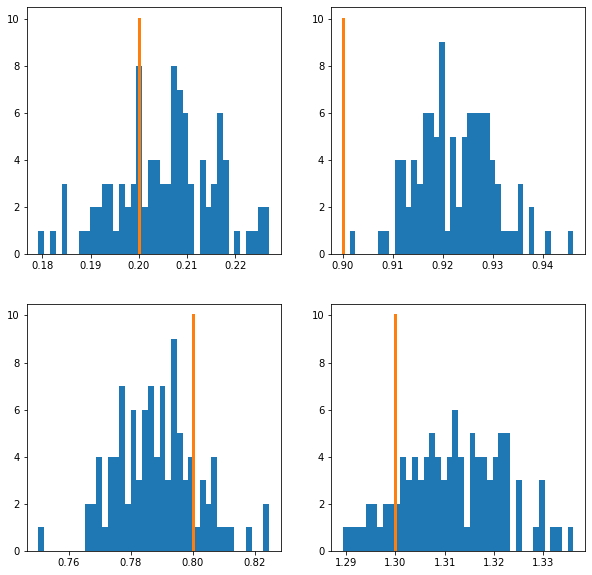

In [23]:
fig,ax = plt.subplots( ndim, 2, figsize=(2*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    ax[i][0].hist( all_mean[i], bins=40)
    ax[i][1].hist( all_rms[i], bins=40)
    
    ax[i][0].plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    ax[i][1].plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

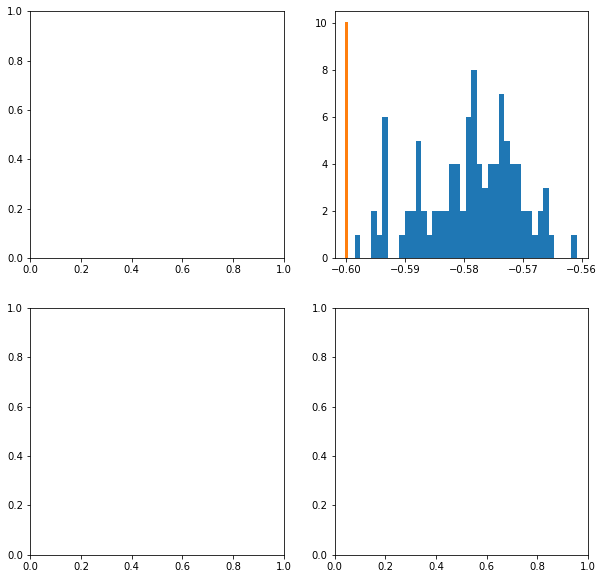

In [24]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5,ndim*5))

ymax = 10

for i in range(0,ndim-1) :
    
    for j in range(i+1,ndim) :
        
        k = ndim - j - 1
        
        ax[i][j].hist( all_rho[i,j], bins=40)
        
        ax[i][j].plot( (true_rho[i][k], true_rho[i][k]), (0, ymax), linewidth=3 )
    


plt.show

In [25]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_mean[fi], true_mu[fi], rms_mean[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.4f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.2054  (true   0.2000), rms   0.0103
  feature 1  :  mean   ave   0.7884  (true   0.8000), rms   0.0131


  feature 0  :  RMS    ave   0.9225  (true   0.9000), rms   0.0079
  feature 1  :  RMS    ave   1.3117  (true   1.3000), rms   0.0102


  feature 0, 1  :  rho    ave  -0.5790  (true  -0.6000), rms   0.0081


  feature 0, 0  :  cov    ave   0.8511  (true   0.8100), rms   0.0145
  feature 0, 1  :  cov    ave  -0.7006  (true  -0.7020), rms   0.0169
  feature 1, 1  :  cov    ave   1.7206  (true   1.6900), rms   0.0267




## Save the simple direct calculation results for setting fit parameter ranges from RMS.

In [26]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [27]:
if have_fits :
    
    for si in range( n_samples ) :
        
        for fi in range( 1,2 ) :
            print("  sample %3d :  mean%d   calc  %8.4f  fit %8.4f" % 
                  (si, fi, all_mean[fi,si], fit_results_mean_val[fi,si]))

  sample   0 :  mean1   calc    0.8072  fit   0.8072
  sample   1 :  mean1   calc    0.8038  fit   0.8038
  sample   2 :  mean1   calc    0.7674  fit   0.7674
  sample   3 :  mean1   calc    0.8013  fit   0.8013
  sample   4 :  mean1   calc    0.7731  fit   0.7731
  sample   5 :  mean1   calc    0.7941  fit   0.7941
  sample   6 :  mean1   calc    0.7917  fit   0.7917
  sample   7 :  mean1   calc    0.7805  fit   0.7805
  sample   8 :  mean1   calc    0.7913  fit   0.7913
  sample   9 :  mean1   calc    0.7891  fit   0.7891
  sample  10 :  mean1   calc    0.7770  fit   0.7770
  sample  11 :  mean1   calc    0.7963  fit   0.7963
  sample  12 :  mean1   calc    0.8051  fit   0.8051
  sample  13 :  mean1   calc    0.7836  fit   0.7836
  sample  14 :  mean1   calc    0.7503  fit   0.7503
  sample  15 :  mean1   calc    0.7839  fit   0.7839
  sample  16 :  mean1   calc    0.7747  fit   0.7747
  sample  17 :  mean1   calc    0.7905  fit   0.7905
  sample  18 :  mean1   calc    0.8245  fit   

   0 : x axis limits:  0.177, 0.229    y axis limits  0.177, 0.229
   1 : x axis limits:  0.747, 0.828    y axis limits  0.747, 0.828


<function matplotlib.pyplot.show(close=None, block=None)>

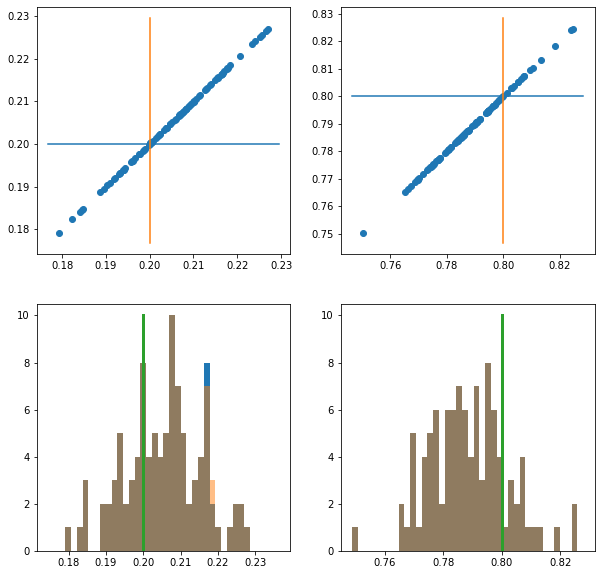

In [28]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    ax[0][fi].scatter( all_mean[fi,:], fit_results_mean_val[fi,:])
    xlow, xhigh = ax[0][fi].get_xlim()
    ylow, yhigh = ax[0][fi].get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    ax[0][fi].plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    ax[0][fi].plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    ax[1][fi].hist( fit_results_mean_val[fi,:], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].hist( all_mean[fi,:], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

   0,  0 : x axis limits:  0.808, 0.899    y axis limits  0.808, 0.899
   0,  1 : x axis limits:  -0.750, -0.659    y axis limits  -0.750, -0.659
   1,  1 : x axis limits:  1.656, 1.791    y axis limits  1.656, 1.791


<function matplotlib.pyplot.show(close=None, block=None)>

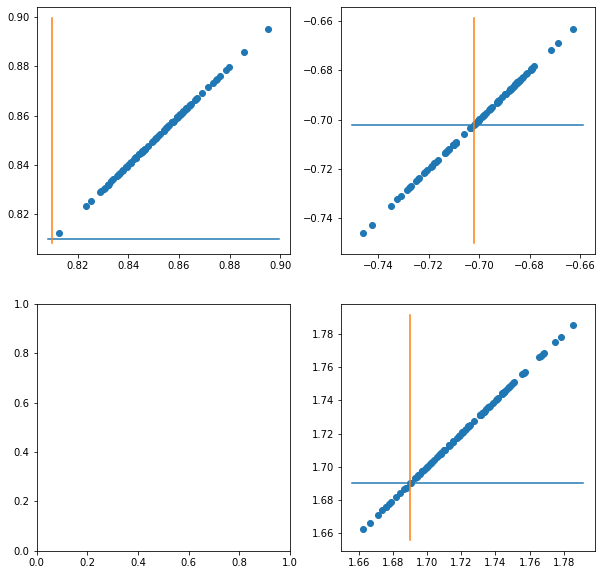

In [29]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))
        ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

plt.show

   0,  0 : x axis limits:  0.803, 0.899    y axis limits  0.000, 10.500
   0,  1 : x axis limits:  -0.756, -0.645    y axis limits  0.000, 9.450
   1,  1 : x axis limits:  1.633, 1.809    y axis limits  0.000, 8.400


<function matplotlib.pyplot.show(close=None, block=None)>

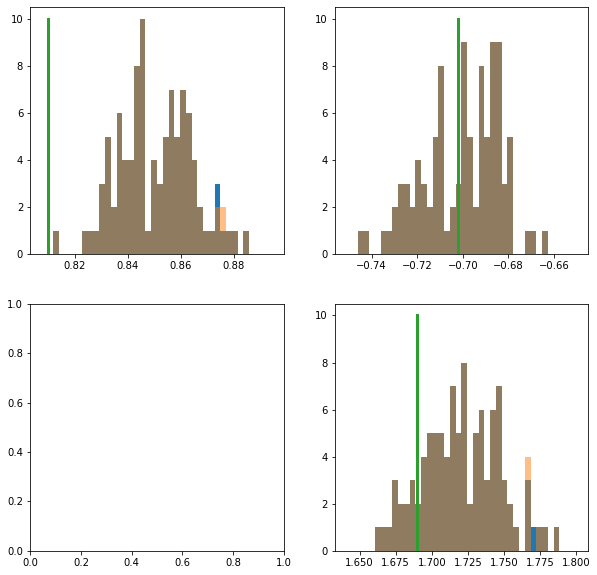

In [30]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

hbins=40
hmax=10

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))

        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

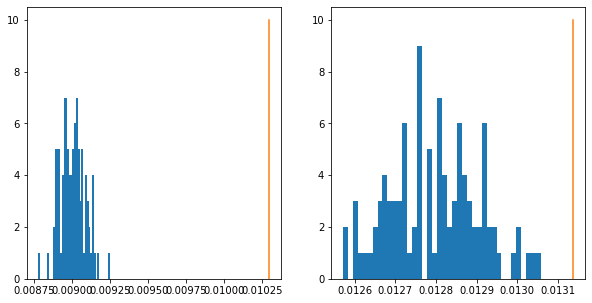

In [31]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    ax[fi].hist( fit_results_mean_err[fi,:], bins=hbins )
    ax[fi].plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

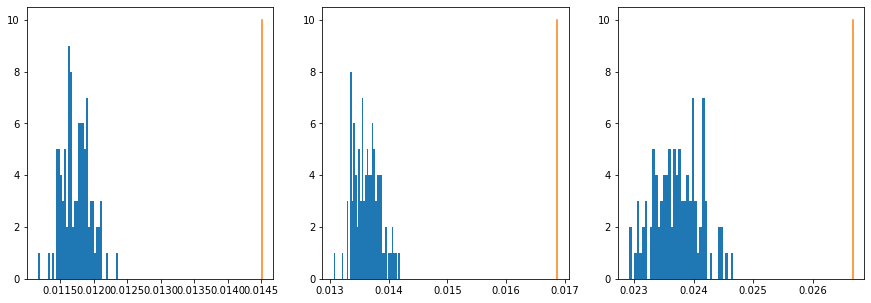

In [32]:
fig,ax = plt.subplots( 1, int((ndim*ndim+ndim)/2), figsize=(5*int((ndim*ndim+ndim)/2),5))

hbins = 40
hmax = 10

ai = 0

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :

        ax[ai].hist( fit_results_cov_err[fi1,fi2,:], bins=hbins )
        ax[ai].plot( (rms_cov[fi1,fi2], rms_cov[fi1,fi2]), (0,hmax) )
        ai = ai + 1
    
plt.show

## Bootstrap error compared with average fit error

In [33]:
print('\n')

for fi in range(ndim) :
    
    print("  mean %d:  rms bootstraps %8.4f,  ave fit err %8.4f    ratio %6.2f |  val. %6.3f, true %6.3f, diff %6.3f"
         % (fi, rms_mean[fi], ave_fit_err_mean[fi], rms_mean[fi] / ave_fit_err_mean[fi], ave_mean[fi], true_mu[fi], ave_mean[fi]-true_mu[fi] ))
    
print('\n')

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        print("  cov%d%d:   rms bootstraps %8.4f,  ave fit err %8.4f    ratio %6.2f |  val. %6.3f, true %6.3f, diff %6.3f"
              % (fi1, fi2, rms_cov[fi1,fi2], ave_fit_err_cov[fi1,fi2], rms_cov[fi1,fi2]/ave_fit_err_cov[fi1,fi2], ave_cov[fi1,fi2], true_cov[fi1,fi2], ave_cov[fi1,fi2]-true_cov[fi1,fi2]) )
        
print('\n')



  mean 0:  rms bootstraps   0.0103,  ave fit err   0.0090    ratio   1.14 |  val.  0.205, true  0.200, diff  0.005
  mean 1:  rms bootstraps   0.0131,  ave fit err   0.0128    ratio   1.03 |  val.  0.788, true  0.800, diff -0.012


  cov00:   rms bootstraps   0.0145,  ave fit err   0.0117    ratio   1.24 |  val.  0.851, true  0.810, diff  0.041
  cov01:   rms bootstraps   0.0169,  ave fit err   0.0136    ratio   1.24 |  val. -0.701, true -0.702, diff  0.001
  cov11:   rms bootstraps   0.0267,  ave fit err   0.0237    ratio   1.12 |  val.  1.721, true  1.690, diff  0.031




## Look for outliers in feature coords and weights

In [34]:
for fi in range( ndim ) :
    
    print( "  feature %2d :  min %12f   max %12f " % ( fi, np.min(train_pts[:,fi]), np.max(train_pts[:,fi])) )

  feature  0 :  min    -4.246143   max     4.477720 
  feature  1 :  min    -5.776488   max     6.868711 


In [35]:
for si in range( n_samples ) :
    
    max_delta_mean = 0
    for fi in range(ndim) :
        delta = fit_results_mean_val[fi,si] - all_mean[fi,si] 
        if np.abs(delta) > max_delta_mean :
            max_delta_mean = delta
        
    print("  %3d : weight range  %12g  to %12f ,   max delta mean  %12f"
         % (si, all_weight_min[si], all_weight_max[si], max_delta_mean ))

    0 : weight range             0  to     0.931576 ,   max delta mean      0.000001
    1 : weight range             0  to     0.426277 ,   max delta mean      0.000000
    2 : weight range             0  to     0.935963 ,   max delta mean      0.000008
    3 : weight range             0  to     0.231240 ,   max delta mean     -0.000011
    4 : weight range             0  to     0.209001 ,   max delta mean      0.000025
    5 : weight range             0  to     0.930854 ,   max delta mean     -0.000028
    6 : weight range             0  to     0.196078 ,   max delta mean      0.000015
    7 : weight range             0  to     1.998691 ,   max delta mean      0.000008
    8 : weight range             0  to     0.888162 ,   max delta mean     -0.000004
    9 : weight range             0  to     1.982200 ,   max delta mean     -0.000005
   10 : weight range             0  to     0.195534 ,   max delta mean      0.000007
   11 : weight range             0  to     0.224644 ,   max delta

## Look deeper into bootstrap with an outlier

In [36]:
si = 35

fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, si)
            
with open(fname,'rb') as f :
            
    final_push_weights_scaled = np.load(f)

/tmp/ipykernel_4045621/2170943159.py:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].hist( np.log10(final_push_weights_scaled), bins=hbins)


ValueError: supplied range of [-inf, 0.7077037404010275] is not finite

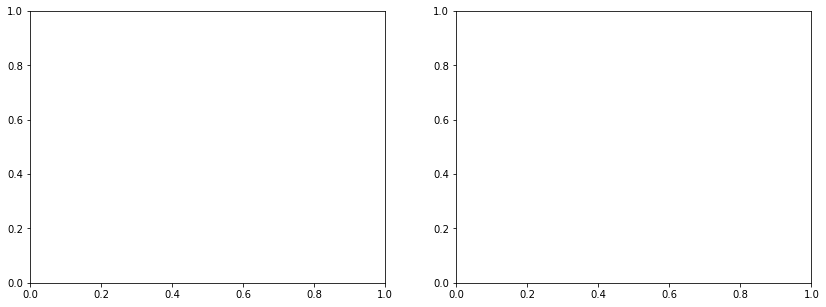

In [37]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(final_push_weights_scaled), bins=hbins)
ax[1].hist( final_push_weights_scaled, bins=hbins)
ax[1].set_yscale('log')

plt.show

In [ ]:
selection_mask = final_push_weights_scaled < 100
train_pts_sel = train_pts[ selection_mask ]
weights_sel = final_push_weights_scaled[ selection_mask ]

print(" number of events before selection  %d" % len(train_pts))
print(" number of events passing selection %d" % len(train_pts_sel))
print(" max weight before selection : %f" % np.max(final_push_weights_scaled))
print(" max weight passing selection: %f" % np.max(weights_sel))

In [ ]:
for fi in range( ndim ) :
    
    fit_mean = fit_results_mean_val[fi,si]
    mean_all_evts = all_mean[fi,si]
    mean_sel = ( np.sum( weights_sel * train_pts_sel[:,fi]) ) / ( np.sum( weights_sel ) )
    mean_diff = mean_sel - mean_all_evts
    print(" %2d :  fit mean  %10f   mean all  %10f   selected  %10f   diff %10f  fit diff %10f" % 
          ( fi, fit_mean, mean_all_evts, mean_sel, mean_diff, (mean_sel-fit_mean) ))

## Look at outlier point

In [ ]:
train_pts_antisel = train_pts[ final_push_weights_scaled > 100 ]
train_pts_antisel.shape

In [ ]:
for fi in range( ndim ) :
    
    sigma = np.sqrt(ave_cov[fi,fi])
    
    print(" %2d :  val %10f   mean %10f   sigma %10f  diff/sigma %10f" %
          (fi, train_pts_antisel[0,fi], ave_mean[fi], sigma, (train_pts_antisel[0,fi]-ave_mean[fi])/sigma )
         )

In [ ]:
true_sig

## Calculate the true weights and compare with unfolding weights